In [12]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

Preparing the data that filled null data by interpolatation. 

In [13]:
df = pd.read_table('drive/MyDrive/Colab Notebooks/data')
df_pivot = pd.pivot_table(df, values = 'value', index = 'field', columns = 'id')
df_pivot.interpolate(limit_direction = 'both', axis = 1, inplace = True)
df_pivot.head()

id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3009,3010,3011,3012,3013,3014,3015,3016,3017,3018,3019,3020,3021,3022,3023,3024,3025,3026,3027,3028,3029,3030,3031,3032,3033,3034,3035,3036,3037,3038,3039,3040,3041,3042,3043,3044,3045,3046,3047,3048
field,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,70.0,3.0,0.0,11.0,1.0,0.0,8.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,14.0,8.0,16.0,7.0,0.0,5.0,4.333333,3.666667,3.0,4.0,0.0,2.0,0.0,0.0,18.0,0.0,4.0,2.0,0.0,...,1.0,1.0,0.0,6.0,2.0,3.0,7.0,2.0,13.0,22.0,12.0,10.000000,20.000000,3.0,1.5,0.0,8.0,2.0,0.0,0.0,6.333333,12.666667,19.0,56.0,6.0,12.0,28.0,18.0,8.0,7.5,7.0,2.0,5.0,6.0,6.333333,6.666667,7.0,8.0,22.0,5.0
1,147.0,10.0,0.0,38.0,1.0,0.0,26.0,2.0,0.0,0.0,1.0,3.0,5.0,5.0,0.0,0.0,1.0,2.0,142.0,1.0,1.0,12.0,4.0,7.0,10.0,0.0,10.0,0.000000,0.000000,9.0,7.0,1.0,5.0,0.0,2.0,28.0,1.0,5.0,5.0,0.0,...,2.0,7.0,7.0,7.0,10.0,5.0,3.5,2.0,20.5,39.0,14.0,21.000000,47.000000,5.0,12.0,4.0,18.0,6.0,0.0,1.0,2.000000,17.000000,32.0,121.0,4.0,6.0,32.0,11.0,10.0,4.0,27.0,24.0,21.0,6.0,11.000000,10.000000,6.0,11.0,9.0,7.0
2,158.0,6.0,0.0,20.0,0.0,0.0,28.0,2.0,0.0,0.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,173.0,0.0,0.0,31.0,4.0,23.0,1.0,2.0,7.0,0.000000,4.500000,9.0,5.0,1.0,4.0,0.0,2.0,21.0,4.0,3.0,1.5,0.0,...,3.0,3.0,8.5,14.0,5.0,5.0,8.0,2.0,17.0,28.0,17.0,11.333333,5.666667,0.0,11.0,2.0,8.0,10.0,0.0,1.0,7.000000,9.000000,35.0,47.0,2.0,19.0,19.5,20.0,12.5,5.0,35.0,2.0,17.0,1.0,17.000000,11.000000,15.0,16.0,31.0,11.0
3,148.0,6.0,0.0,22.0,3.0,1.0,29.0,1.0,0.0,0.0,0.0,3.0,5.0,4.0,0.0,0.0,0.0,4.0,49.0,24.5,0.0,25.0,2.0,34.0,18.5,3.0,1.5,0.000000,0.000000,7.0,9.0,0.0,0.0,2.0,2.0,21.0,12.0,3.0,3.0,1.0,...,1.0,2.0,3.0,6.0,14.0,1.0,8.0,12.5,17.0,25.0,15.0,12.000000,38.000000,4.0,8.0,1.0,19.0,3.0,0.0,2.0,1.000000,3.000000,40.0,68.0,11.0,8.0,57.0,22.0,14.0,5.0,45.0,4.0,13.0,2.0,12.000000,14.000000,12.0,15.0,46.0,8.0
4,143.0,7.0,0.0,12.0,0.0,0.0,30.0,5.0,0.0,0.0,0.0,8.0,2.0,1.0,0.0,0.0,0.0,1.0,117.0,0.0,0.0,42.0,8.0,24.0,7.0,0.0,14.0,0.000000,1.000000,4.0,4.0,1.0,0.0,2.0,2.0,18.0,1.0,1.5,2.0,0.0,...,1.0,0.0,1.0,6.0,7.0,4.0,9.0,0.0,15.0,18.0,15.0,12.000000,24.000000,4.0,10.0,3.0,18.0,10.0,0.0,1.0,2.000000,3.000000,24.0,49.0,0.0,11.0,20.0,13.0,9.0,3.0,26.0,0.0,14.0,1.0,16.000000,13.000000,23.0,9.0,17.0,4.0


Preparing the training, validation and test data sets.\
Making sequences with a length of 50

In [14]:
l = 50
X_train = []
y_train = []
for j in range(2001):
    tmp = np.array(df_pivot[j])
    for i in range(len(tmp)-l):
        X_train.append(tmp[i:i+l])
        y_train.append(tmp[i+l])
X_train = np.array(X_train)
y_train = np.array(y_train)

X_valid = []
y_valid = []
for j in range(2001,2501):
    tmp = np.array(df_pivot[j])
    for i in range(len(tmp)-l):
        X_valid.append(tmp[i:i+l])
        y_valid.append(tmp[i+l])
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

X_test = []
y_test = []
for j in range(2501, 3049):
    tmp = np.array(df_pivot[j])
    i = len(tmp)-l-1
    X_test.append(tmp[i:i+l])
    y_test.append(tmp[i+l])
X_test = np.array(X_test)
y_test = np.array(y_test)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(916458, 50)
(916458,)
(229000, 50)
(229000,)
(548, 50)
(548,)


In [16]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)

X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(916458, 50, 1)
(916458, 1)
(229000, 50, 1)
(229000, 1)
(548, 50, 1)
(548, 1)


In [18]:
length_of_sequence = 50
in_out_neurons = 1
n_hidden = 256
batch_size = 128
n_epoch =10

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), return_sequences=False))
model.add(Dense(in_out_neurons))
model.add(Activation("relu"))
optimizer = Adam(learning_rate=0.01)
model.compile(loss="mean_squared_error", optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 256)               264192    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(X_train, y_train, batch_size = batch_size, epochs = n_epoch, verbose=2)

Epoch 1/10
7160/7160 - 49s - loss: 230.4992
Epoch 2/10
7160/7160 - 49s - loss: 211.2621
Epoch 3/10
7160/7160 - 49s - loss: 201.4957
Epoch 4/10
7160/7160 - 49s - loss: 198.8451
Epoch 5/10
7160/7160 - 49s - loss: 197.3930
Epoch 6/10
7160/7160 - 49s - loss: 193.5037
Epoch 7/10
7160/7160 - 49s - loss: 190.0424
Epoch 8/10
7160/7160 - 49s - loss: 189.0747
Epoch 9/10
7160/7160 - 49s - loss: 184.5060
Epoch 10/10
7160/7160 - 49s - loss: 191.2719


R squared.

In [20]:
y_valid_pred = model.predict(X_valid)
y_test_pred = model.predict(X_test)
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.divide(residual, total))
  return r2
print("R2_valid = ",R_squared(y_valid, y_valid_pred).numpy())
print("R2_test = ",R_squared(y_test, y_test_pred).numpy())

R2_valid =  0.7192161481630642
R2_test =  0.8470880606783141


Mean squared error.

In [21]:
mse = MeanSquaredError(reduction="auto", name="mean_squared_error")
print("MSE_valid = ",mse(y_valid,y_valid_pred).numpy())
print("MSE_test = ",mse(y_test, y_test_pred).numpy())

MSE_valid =  204.11581
MSE_test =  107.34743


Create a scatterplot of the real test values versus the predicted values. 

Text(0, 0.5, 'Predicted Y')

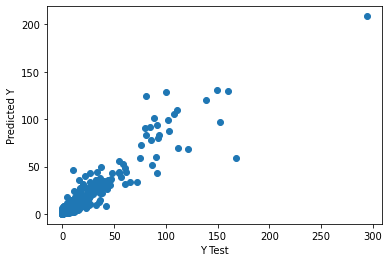

In [22]:
plt.scatter(y_test.reshape(-1), y_test_pred.reshape(-1))
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')